SAS & HSE, Applied Time Series Forecasitng , Winter 2022

<font color="blue"> Lesson #2: Simple Exponential Smoothing Model </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** simple exponential smoothing, adaptive exponential smoothing, retail time series

**Your fitback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [53]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import warnings as w
w.filterwarnings('ignore')

from matplotlib import gridspec
import matplotlib.pyplot as plt


# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Typical TS for SES Model

## TS in Retail

In [4]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', parse_dates=['Dates'], dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

Item:  165  Item:  969  ...  Item: 2806  Item: 2808
Timestamp                           ...                        
2005-01-11         NaN         2.0  ...         NaN         NaN
2005-01-12         NaN         5.0  ...         NaN         NaN
2005-01-13         NaN         2.0  ...         NaN         NaN
2005-01-14         NaN        42.0  ...         NaN         NaN
2005-01-15         NaN         NaN  ...         NaN         NaN

[5 rows x 11 columns]

In [5]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

Item:  165  Item:  969  ...  Item: 2806  Item: 2808
Timestamp                           ...                        
2007-01-01         NaN         NaN  ...         NaN         NaN
2007-01-02         NaN        21.0  ...         3.0         5.0
2007-01-03         NaN        10.0  ...         0.0         2.0
2007-01-04         NaN         NaN  ...         NaN         1.0
2007-01-05         NaN         3.0  ...         4.0         1.0

[5 rows x 11 columns]

**Questions** 
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

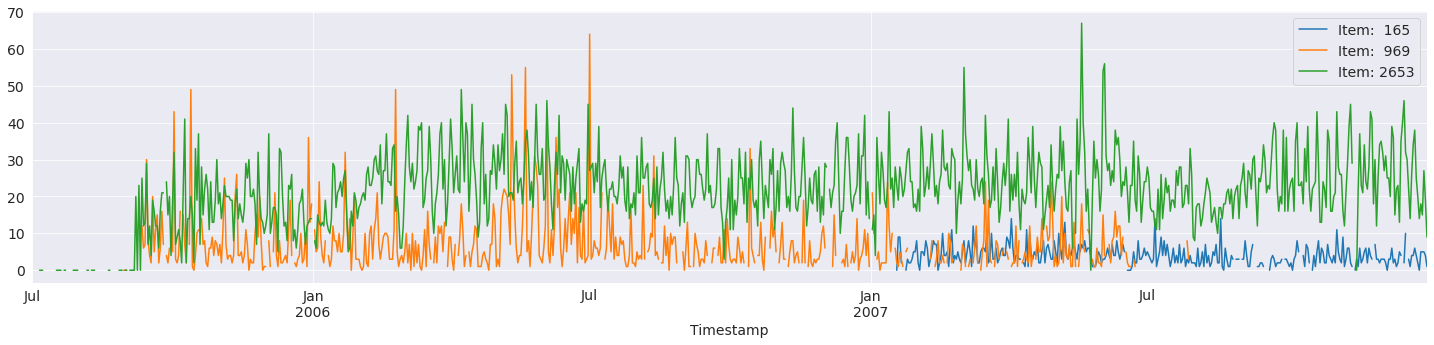

In [6]:
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot()

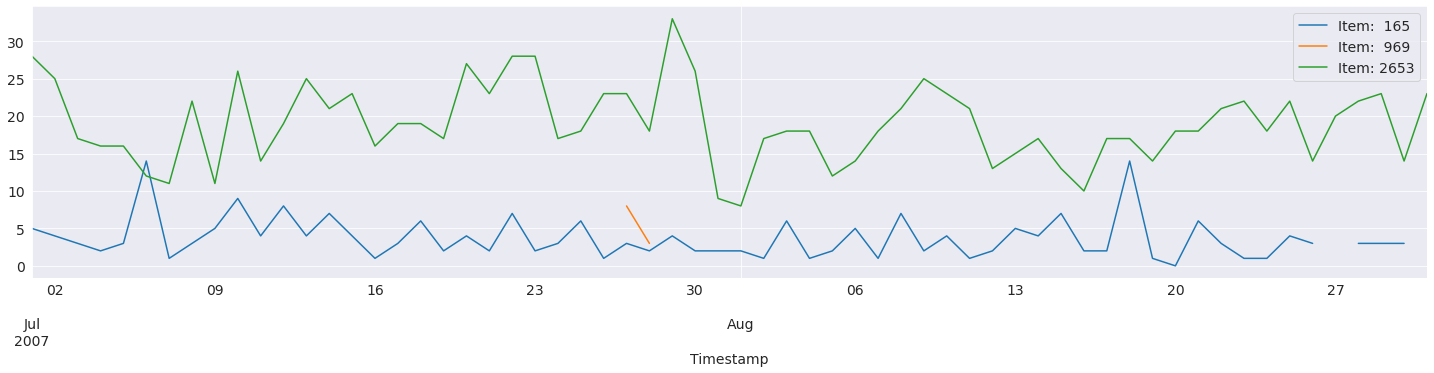

In [55]:
ts.loc['2007-07-01':'2007-08-31', ts.columns[range(3)]].plot()

**Questions**

 - What are key aspects of these retail ts?


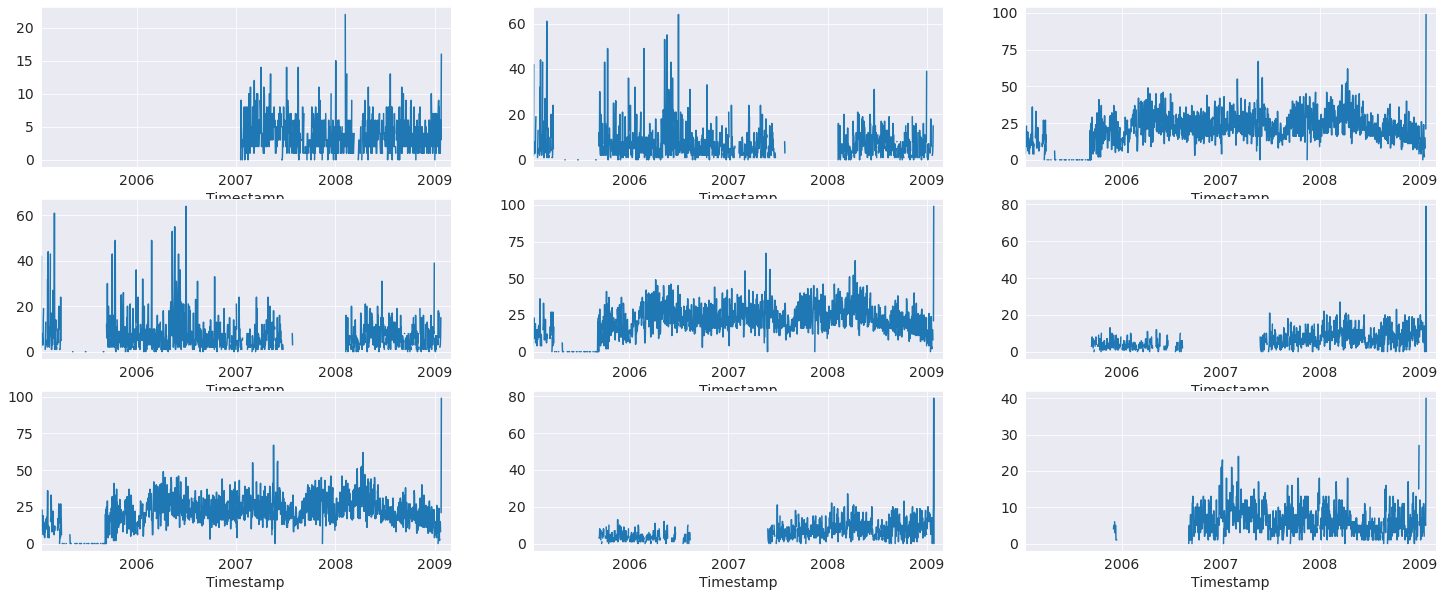

In [7]:
fig = plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(3, 3)
for i in range(3):
    for j in range(3):
        fig.add_subplot(gs[i,j])
        ts.loc[:, ts.columns[i+j]].plot()

**Questions**

 - Any idea how to predict such ts?
 - Can you describe statistical model for such ts?

###### Answer



$$y_{t} = l_t + \color{red}{\varepsilon_t},$$

where $l_t$ $-$ changing slowly level of time series,

$\varepsilon_t~-$ error component (unobserved noise)

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$

where $\hat l_t~-$ an estimation of level


## Moving Average

**Rolling window n**
       $$\hat y_{t+d} = \frac{1}{n}\left(y_{t-n+1}+\dots+ {y}_t\right)$$
   
**All points in  $[t-n+1, t]$ has the same weight**
                                   $$w = \frac{1}{n}$$
**Other points has weight**
                                    $$w = 0$$

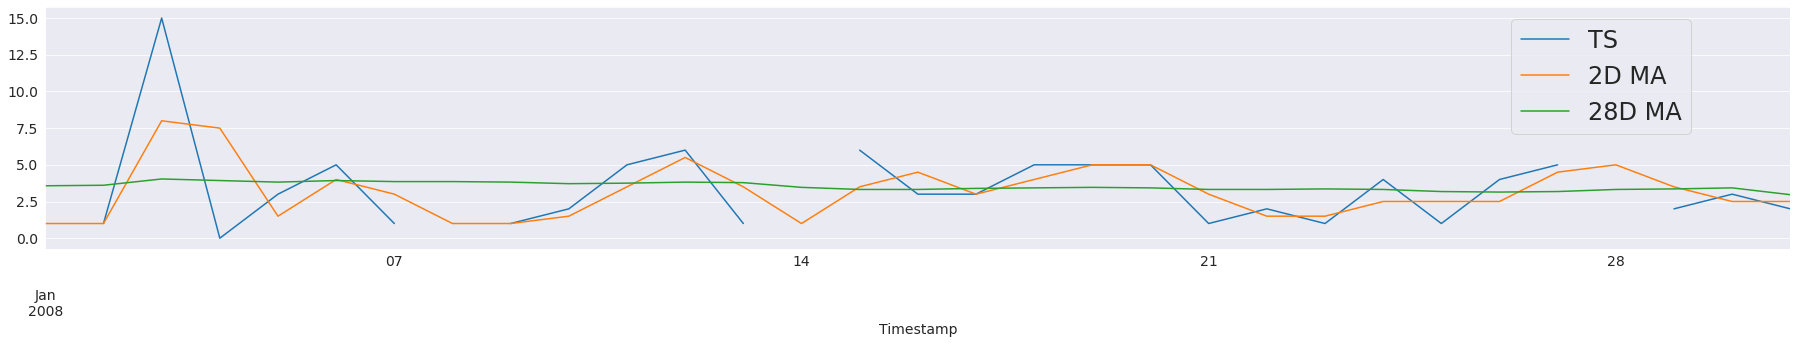

In [8]:
# Rolling moving (n = 2 и n=28)
# Note: replace NaN befor average calculation
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts[u'Item:  165'].fillna(method='pad').rolling(2).mean().loc['2008-01-01':'2008-01-31'].plot(label='2D MA', figsize=(25,5))
ts[u'Item:  165'].fillna(method='pad').rolling(28).mean().loc['2008-01-01':'2008-01-31'].plot(label='28D MA', figsize=(25,5))

plt.legend(bbox_to_anchor=(0.95, 1), prop={'size':24})
plt.tight_layout()

**Expanding window**
       $$\hat y_{t+d} = \frac{1}{t}\left(y_{1}+\dots+ {y}_t\right)$$
   
**All time points in $[1, t]$ has the same weight**
                                   $$w = \frac{1}{t}$$   

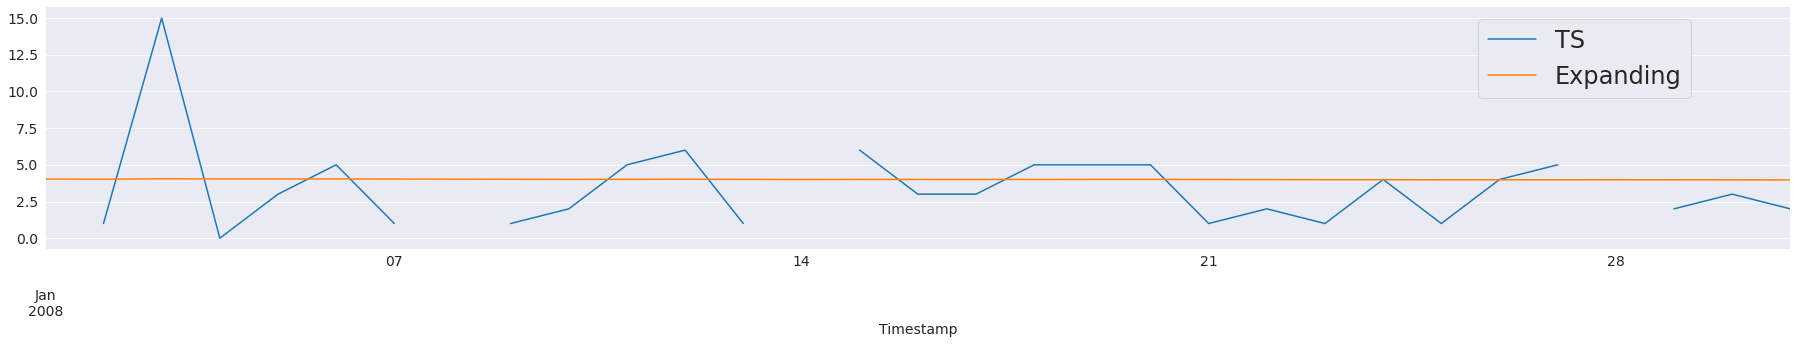

In [9]:
# Expanding windod
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].expanding().mean().loc['2008-01-01':'2008-01-31'].plot(label='Expanding', figsize=(25,5))

plt.legend(bbox_to_anchor=(0.95, 1), prop={'size':24})
plt.tight_layout()
sns.despine()

**Questions**

 - What are analytical disadvantages of using movinag average algorithm?


## Exponentially Wighted Moving Average

**Exponentialy diminishing weights**
    $$\hat y_{t+d}= \alpha y_t + \alpha \left(1-\alpha\right)y_{t-1} + \alpha \left(1-\alpha\right)^2y_{t-2}+\dots = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau$$
   
**Weight for time point in moment $\tau$**
    $$w_\tau = \alpha\cdot (1-\alpha)^{t-\tau}$$  


In [10]:
# look at timestamp weights
t = 10
alpha_set = [0.001, 0.1, 0.15, 0.2, 0.5, 0.9]
pd.DataFrame(data = [[a*(1-a)**(t-tau) for a in alpha_set] for tau in range(1,t+1,1)], columns = [r'\alpha=' + str(x) for x in alpha_set], index = range(1,t+1,1)).sort_index(ascending = False)

\alpha=0.001  \alpha=0.1  \alpha=0.15  \alpha=0.2  \alpha=0.5    \alpha=0.9
10      0.001000    0.100000     0.150000    0.200000    0.500000  9.000000e-01
9       0.000999    0.090000     0.127500    0.160000    0.250000  9.000000e-02
8       0.000998    0.081000     0.108375    0.128000    0.125000  9.000000e-03
7       0.000997    0.072900     0.092119    0.102400    0.062500  9.000000e-04
6       0.000996    0.065610     0.078301    0.081920    0.031250  9.000000e-05
5       0.000995    0.059049     0.066556    0.065536    0.015625  9.000000e-06
4       0.000994    0.053144     0.056572    0.052429    0.007812  9.000000e-07
3       0.000993    0.047830     0.048087    0.041943    0.003906  9.000000e-08
2       0.000992    0.043047     0.040874    0.033554    0.001953  9.000000e-09
1       0.000991    0.038742     0.034743    0.026844    0.000977  9.000000e-10

window ~ $\frac{1}{2\alpha}$

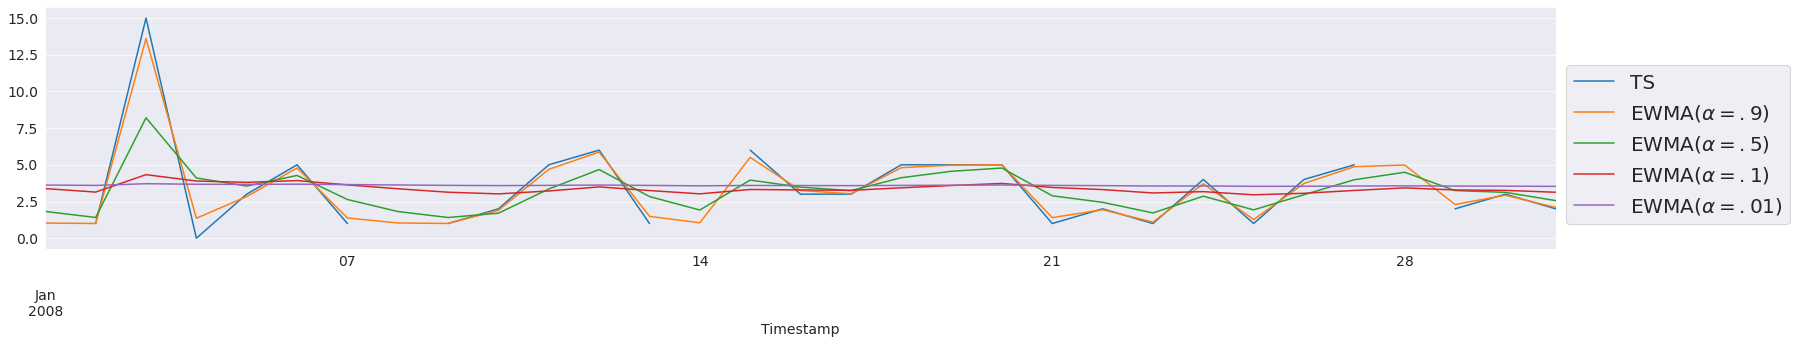

In [11]:
# Averaging with exponential weights
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.9$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.5).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.5$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.1).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.1$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.01).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.01$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1, 0.8), prop={'size':20})
plt.tight_layout()


**Parameter $\alpha$ drives the depth of the historical period to be considered!**

$\alpha \uparrow 1 \; \Rightarrow$ EWMA is closer to Moving Average with window = 1,

$\alpha \downarrow 0 \; \Rightarrow$ EWMA is closer to Moving Average with expanding window.

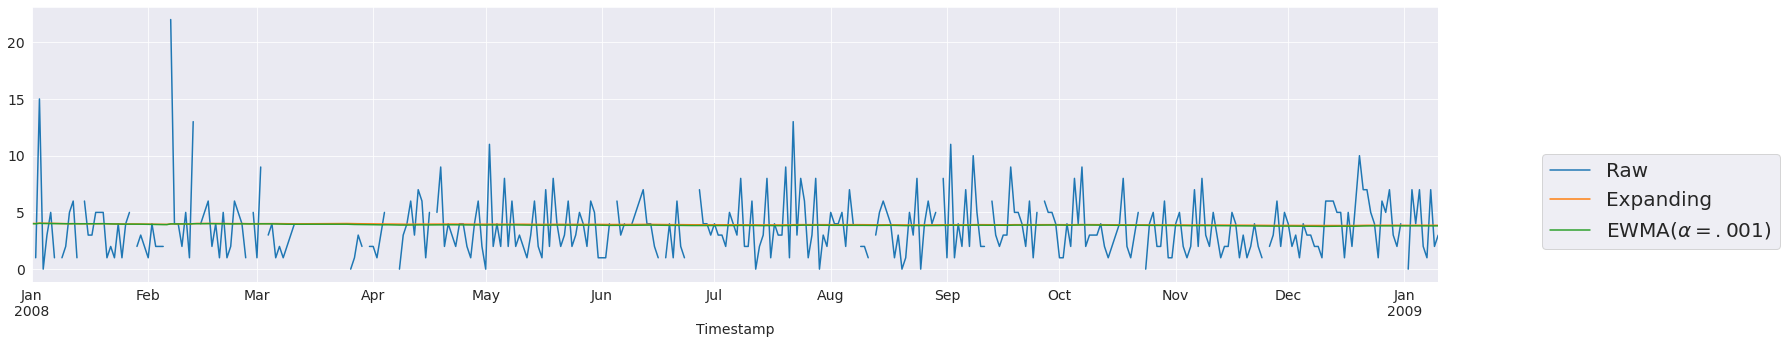

In [12]:
# Compare EWMA (alpha = 0.001) and Expanding 
ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').expanding().mean().loc['2008-01-01':'2009-01-10'].plot(label='Expanding')
ts[u'Item:  165'].ewm(alpha=0.001).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.001$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()

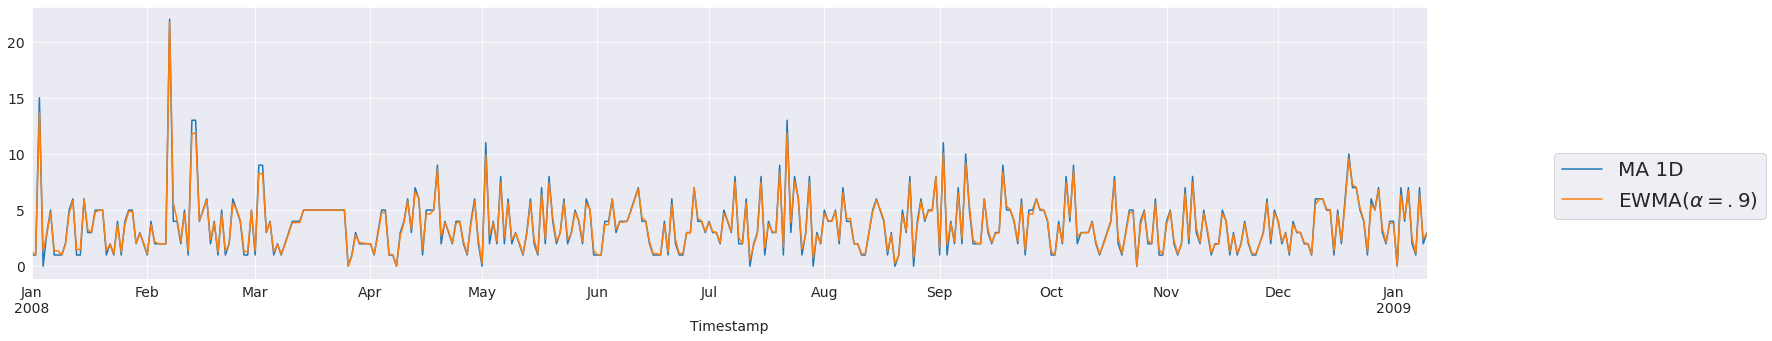

In [13]:
# Compare EWMA (alpha = 0.9) and MA (window = 1) 
# ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').rolling(1).mean().loc['2008-01-01':'2009-01-10'].plot(label='MA 1D')
ts[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.9$)', figsize=(25,5)) 
plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})

# Simple Exponential Smoothing

## A bit of Theory

**Sum notation**:
$$\hat{y}_{t+d} = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau~~~~~(1)$$ 

**Question:**
 * What is the problem with this formla (1)?
 * Hint: calculate sum of weights of time series points.

**Recurrent formula notation:**
$$\hat{y}_{t+d} = \alpha\cdot y_t+ (1-\alpha)\cdot \hat{y}_t = \hat y_t + \alpha \cdot \color{red}{e_t}$$
where ${e_t = y_t - \hat y_t }$




## SES Realization

In [14]:
# Example of realization

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter

def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y) 
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [15]:
# Forecast delay = 1
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [16]:
# ES params
Params ={'alpha':0.1}

# generate forecasts for each Item
for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, Params)

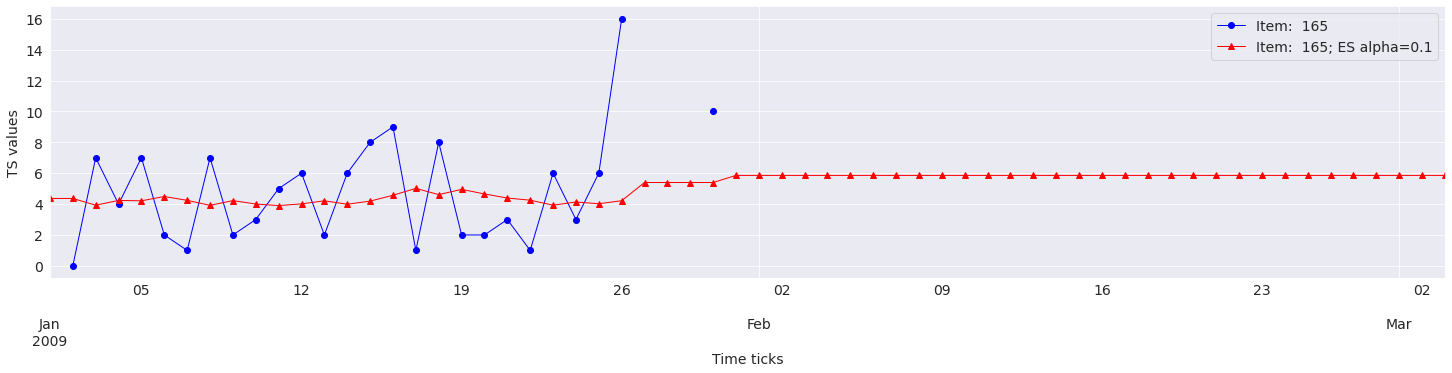

In [17]:
# show SES forecast alpha = 0.1
def plotTSForecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
    plt.xlabel("Time ticks")
    plt.ylabel("TS values")
    plt.legend()
    return ax

plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

**Question:**
 * Why the forecasts values for 27th, 28th, 29th and 30th of January are the same?
 * When does the last change of the forecast value occur?  

In [18]:
# Generate forecast for h = 30
h = 30
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':0.1})

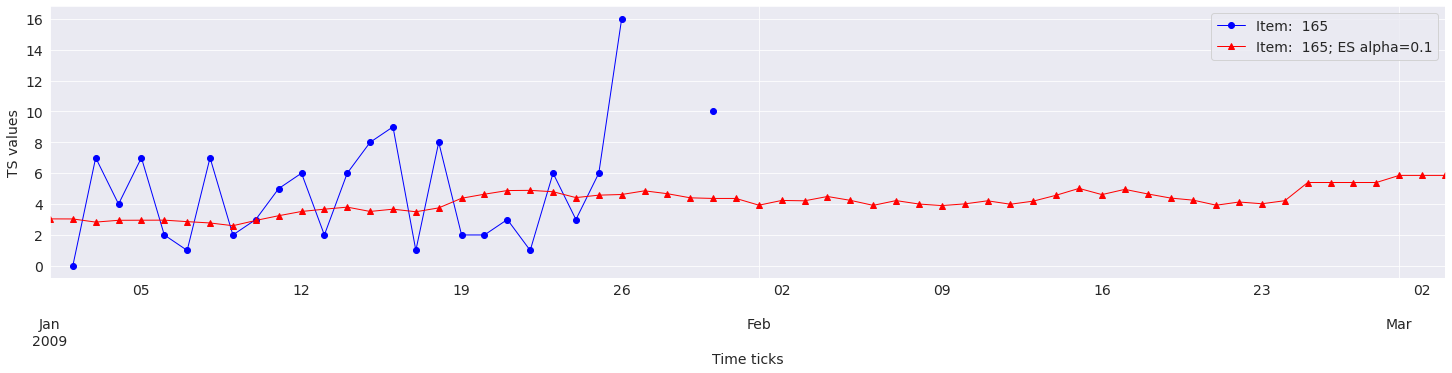

In [19]:
# show forecast h = 30, alpha = 0.1
plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

## Search for the optimal $\alpha$ 

In [20]:
def build_forecast(h, ts, AlgName, AlgTitle, ParamsArray, step='D'):
  'grid'
    
  FRC_TS = dict()

  for p in ParamsArray:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)
          # frc_ts[cntr] = AlgName(ts[cntr], h, p)
      
#         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
      FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
  
  return FRC_TS

In [56]:
#Fit parameters
ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)

Loss of the SES forecast for all history

In [57]:
# intoduce loss function
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
  qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
  return qlt.mean() , (x-y).abs()

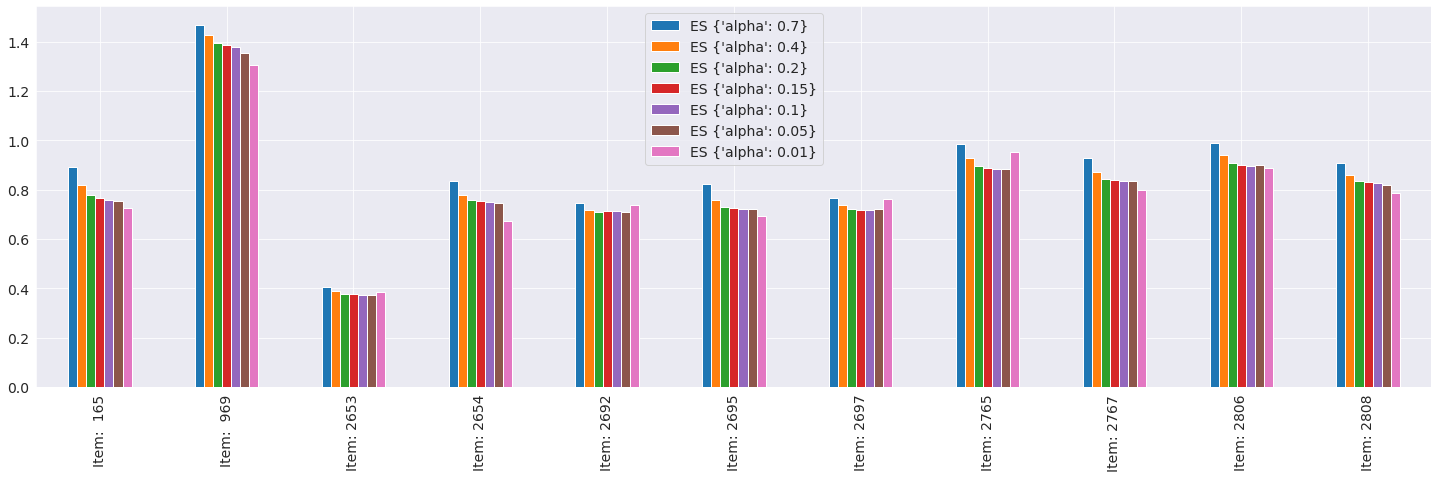

In [58]:
# compare ES parameters
quality_wholehist = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within all 1500 steps
for param_cntr in sorted(quality_wholehist.columns):
    frc_ts = FRC_TS[param_cntr]
    quality_wholehist[param_cntr],_ = qualityMAPE(ts, frc_ts.loc[ts.index])

ax = quality_wholehist.plot.bar(figsize = (25,7))

* The optimal value of $\alpha$ is about $0.1$ 

Loss for first time series point

Text(0, 0.5, 'MAPE')

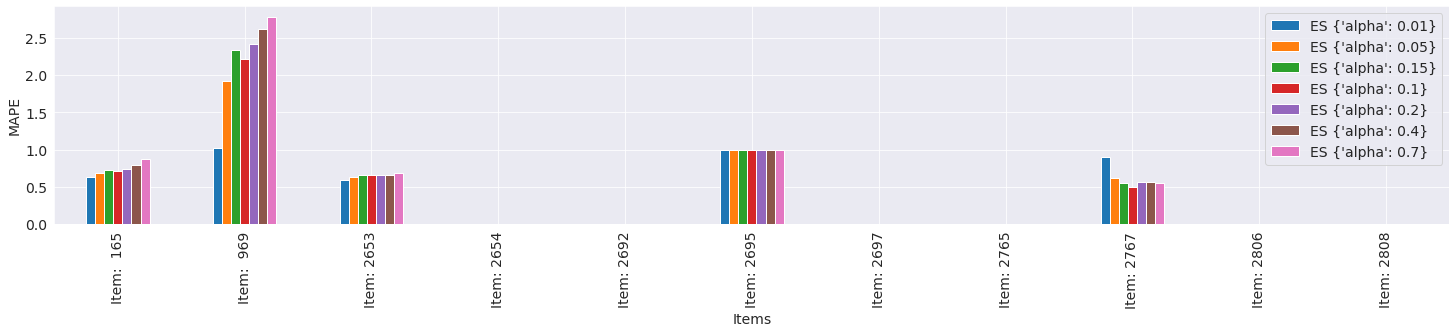

In [24]:
quality_initphase = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality in first 100 steps
init_steps = 100
for model in quality_initphase.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(init_steps))
        quality_initphase[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

ax = quality_initphase[sorted(quality_initphase.columns)].plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

**Question:**

Why is loss function  not calculated for some items?

(Hint: see definition of loss function)

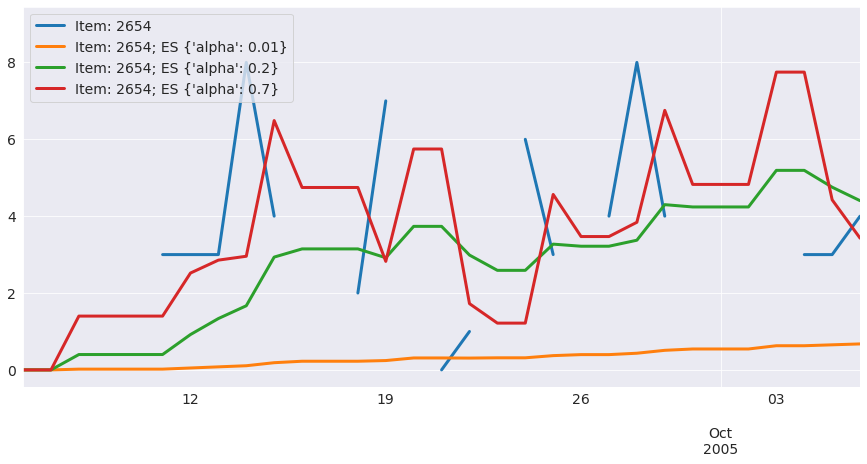

In [25]:
# ts VS forecast in first 100 steps
model_num = [0,4,6]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 3 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[frc_ts.columns[ts_num]+'; '+Models[model]] = frc_ts[frc_ts.columns[ts_num]]

ix = pd.date_range(ts[ts.columns[ts_num]].first_valid_index()+timedelta(140), ts[ts.columns[ts_num]].first_valid_index()+timedelta(170))
plot_ts.loc[ix].plot(figsize = (15, 7), linewidth=3.0) # :250

**Wow: we need to use big $\alpha$ for first steps of ES!** 
    - We need to modify algorithm for tirst steps!

**Question:**
   * How algorithm can be modified for first steps?

## Examples of modification (self-study)

* First variant: let's make $\alpha$ higher for first time point of TS

In [26]:
def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

* Second variant: normalize weights of ES: $1 - (1-\alpha)^t$

In [27]:
def NormExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    
    y = 0
    norm = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                norm=1  # initialize when first data point comes
            norm = norm*(1-alpha)
            y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y/(1-norm)
    return FORECAST

In [28]:
#Fit parameters

ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod': 5} for alpha in ALPHA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray))
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'NormExponentialSmoothing', AlgTitle='NES' ,ParamsArray = ESParamsArray))

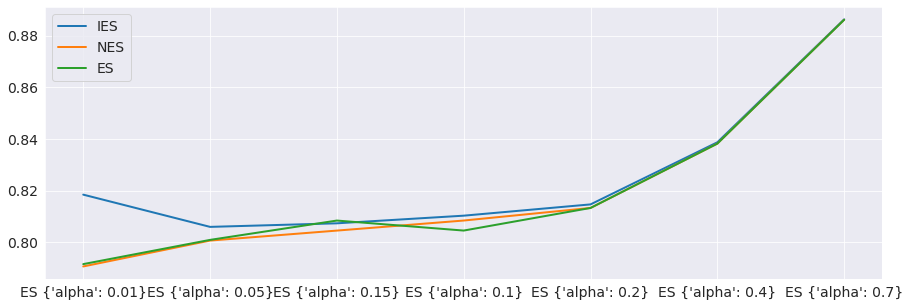

In [29]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMAPE(ts, frc_ts)


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES', figsize = (15, 5),linewidth=2.0)
# ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:14]), (2, 7)).T , rotation=90)
plt.legend()

* Conclusion: **The optimal value of $\alpha$ is about the same for all ES modifications.**

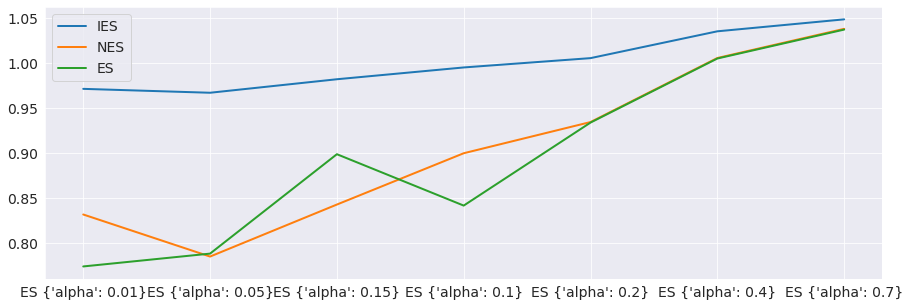

In [30]:
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES',  figsize = (15, 5),linewidth=2.0)
plt.legend()

## Adaptive ES (self-study)
Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, глава 1

Tracking signal see 1.

$e_t = y_t - \hat{y}_t$

$\tilde{e}_t = \gamma e_{t-1} + (1-\gamma) \tilde{e}_{t-1}$

$\overline{e}_t = \gamma \left|e_{t-1}\right| + (1-\gamma) \overline{e}_{t-1}$

* Tracking signal

$$K_t = \frac{\tilde{e}_t}{\overline{e}_t}$$

* to do algorithm more stable 
$$\alpha_t = \left|K_{t-1}\right|$$

In [31]:
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

In [32]:
#Fit parameters
GAMMA = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
alpha = 0.1
AESParamsArray = [{'alpha':alpha, 'gamma':gamma, 'AdaptationPeriod': 5} for gamma in GAMMA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'AdaptiveExponentialSmoothing', AlgTitle='AES' ,ParamsArray = AESParamsArray))

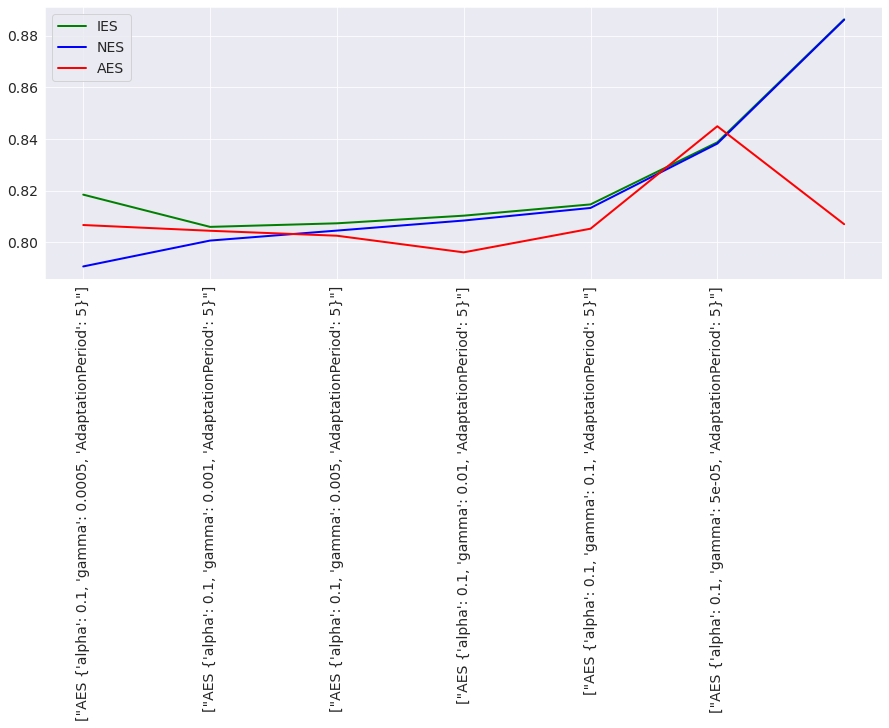

In [33]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMAPE(ts, frc_ts)

QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(color='g', label='IES', figsize = (15, 5), linewidth=2)
QualityStr[sorted(QualityStr.columns)[21:]].mean().plot(color='b', label='NES', linewidth=2 )
ax = QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(color='r', label='AES', linewidth=2 )
ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:7]), (1, 7)).T , rotation=90)
plt.legend()
# ax.set_xticklabels(df.C, rotation=90)

**Conclusion**: Adaptive ES has less loss (by optimal value of parameters) than other modifications ES  

In [34]:
# Sort Quality
QualityStr[QualityStr.columns[:14]].mean().sort_values()

ES {'alpha': 0.01}                                            0.791620
AES {'alpha': 0.1, 'gamma': 0.005, 'AdaptationPeriod': 5}     0.796167
ES {'alpha': 0.05}                                            0.800987
AES {'alpha': 0.1, 'gamma': 0.001, 'AdaptationPeriod': 5}     0.802603
AES {'alpha': 0.1, 'gamma': 0.0005, 'AdaptationPeriod': 5}    0.804516
ES {'alpha': 0.1}                                             0.804595
AES {'alpha': 0.1, 'gamma': 0.01, 'AdaptationPeriod': 5}      0.805314
AES {'alpha': 0.1, 'gamma': 0.0001, 'AdaptationPeriod': 5}    0.806740
AES {'alpha': 0.1, 'gamma': 5e-05, 'AdaptationPeriod': 5}     0.807060
ES {'alpha': 0.15}                                            0.808468
ES {'alpha': 0.2}                                             0.813339
ES {'alpha': 0.4}                                             0.838226
AES {'alpha': 0.1, 'gamma': 0.1, 'AdaptationPeriod': 5}       0.844946
ES {'alpha': 0.7}                                             0.886124
dtype:

## Case when SES doesn't work

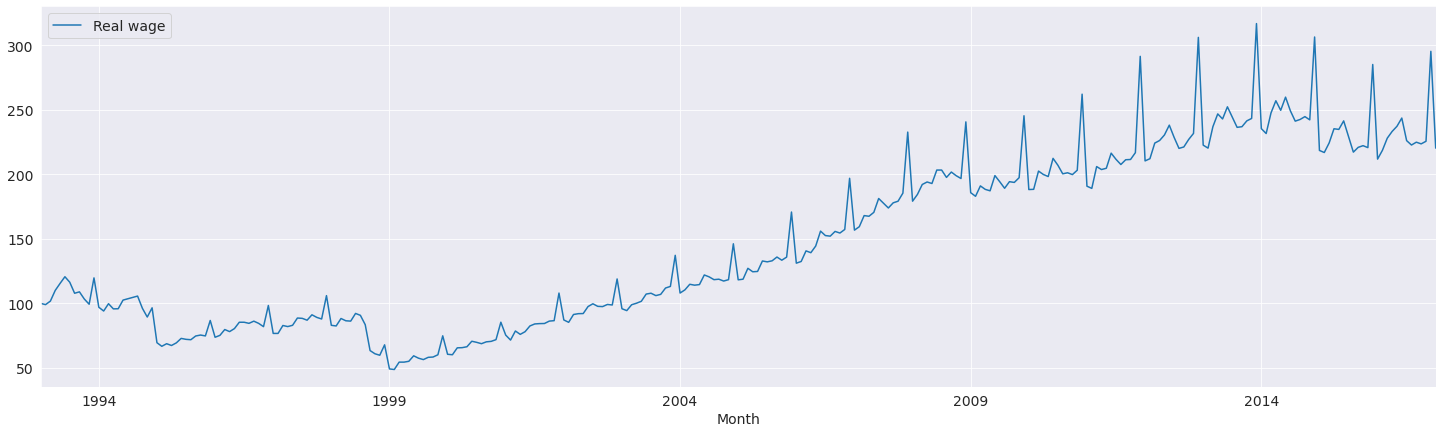

In [35]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot(figsize=(25,7))

**Questions** 
    - Which charachteristic of TS can you mention so far?

Wage ts forecast with SES alpha =0.1

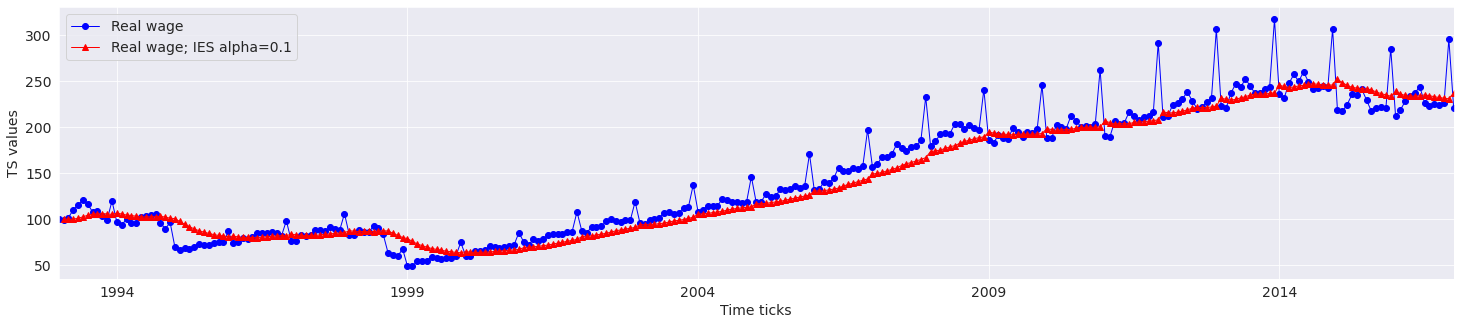

In [36]:
ESParamsArray = [{'alpha':0.1, 'AdaptationPeriod':10}]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'SimpleExponentialSmoothing', AlgTitle='SES' ,ParamsArray = ESParamsArray)

plotTSForecast(wage.loc['1993-01-01':'2017-01-01'], FRC_WAGE[list(FRC_WAGE)[0]].loc['1993-01-01':'2017-01-01']
               , ts_num=0, alg_title='IES alpha=0.1')

**Question**
  * What indicates that forecast is inadequate (=there could be more proper forecastl)?

Search for the optimal $\alpha$ 

In [59]:
ALPHA = np.linspace(0.01,0.99,99)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'SimpleExponentialSmoothing', AlgTitle='SES' ,ParamsArray = ESParamsArray)

In [38]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09-01':'2018-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()

SES {'alpha': 0.38, 'AdaptationPeriod': 10}                   0.058839
SES {'alpha': 0.37, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.39, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.4, 'AdaptationPeriod': 10}                    0.058872
SES {'alpha': 0.36000000000000004, 'AdaptationPeriod': 10}    0.058888
                                                                ...   
SES {'alpha': 0.05, 'AdaptationPeriod': 10}                   0.129426
SES {'alpha': 0.04, 'AdaptationPeriod': 10}                   0.147997
SES {'alpha': 0.03, 'AdaptationPeriod': 10}                   0.175454
SES {'alpha': 0.02, 'AdaptationPeriod': 10}                   0.219394
SES {'alpha': 0.01, 'AdaptationPeriod': 10}                   0.298435
Length: 99, dtype: float64

draw the forecast with optimial value $\alpha $

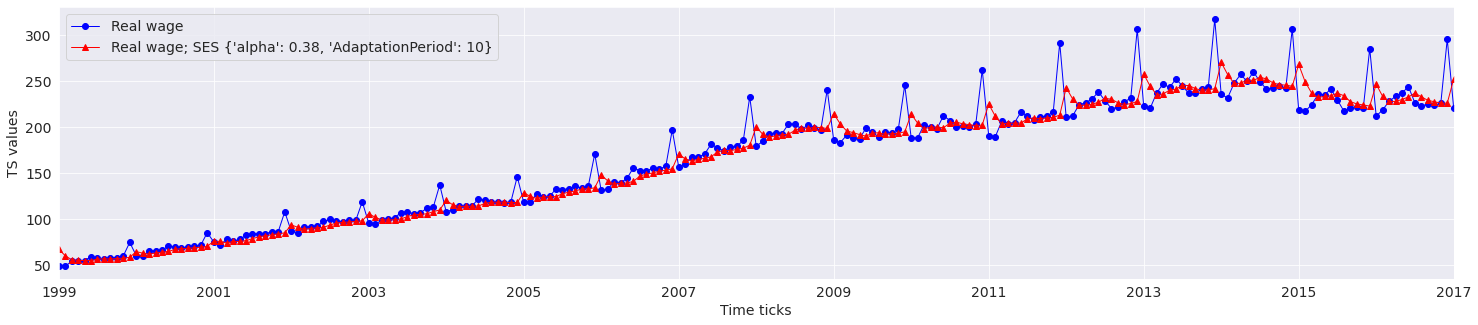

In [39]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1999-01-01':'2017-01-01'], FRC_WAGE[algName].loc['1999-01-01':'2017-01-01']
               , ts_num=0, alg_title=algName)

**Question**
  * Is forecast still inadequate?

Calculate loss of the forecast of TS in [02.2016, 01.2017]

In [40]:
qualityMAPE(wage.loc['2016-02-01':'2017-01-01'], FRC_WAGE[algName].loc['2016-02-01':'2017-01-01'])[0]

Real wage    0.056378
dtype: float64

SES to Yearly Wage Data

In [41]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year[-4:]

Real wage
Month                
2013-01-01     2940.9
2014-01-01     3007.2
2015-01-01     2766.7
2016-01-01     2790.6

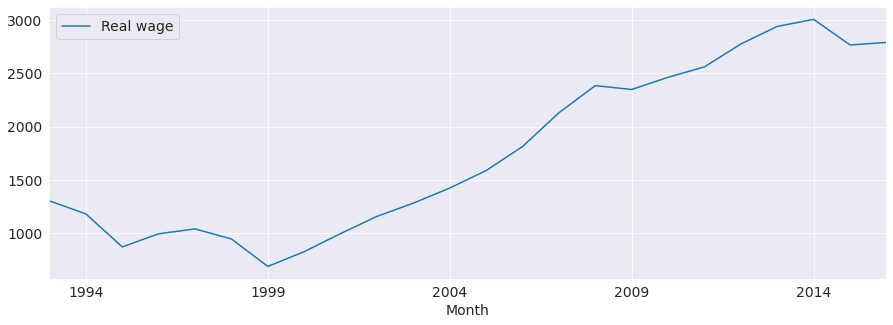

In [42]:
wage_year.plot(figsize=(15,5))

Search of optimal $\alpha$ for aggregated data

In [43]:
ALPHA = np.linspace(0.01,1,100)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, AlgName =  'SimpleExponentialSmoothing', AlgTitle='IES'
                              ,ParamsArray = ESParamsArray, step='12MS')

In [44]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['1999-01':'2010-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:5]

IES {'alpha': 1.0, 'AdaptationPeriod': 10}                   0.132986
IES {'alpha': 0.99, 'AdaptationPeriod': 10}                  0.133505
IES {'alpha': 0.98, 'AdaptationPeriod': 10}                  0.134027
IES {'alpha': 0.97, 'AdaptationPeriod': 10}                  0.134553
IES {'alpha': 0.9600000000000001, 'AdaptationPeriod': 10}    0.135084
dtype: float64

Forecast with optimial value  $\alpha$

MAPE: Real wage    0.047746
dtype: float64


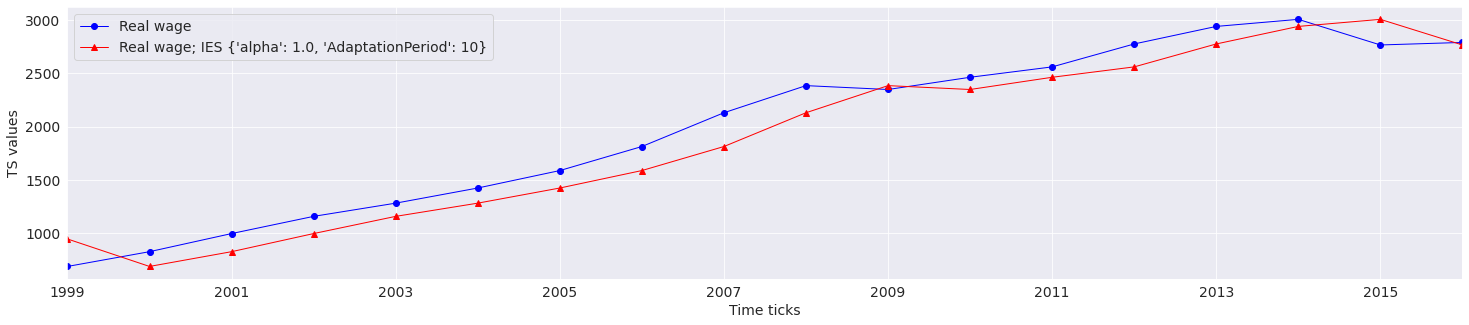

In [45]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=algName)

print('MAPE: %s' % qualityMAPE(wage_year.loc['2015-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['2015-01-01':'2016-01-01'])[0])

**Remember**
   - Empirical rules:

  if $\alpha^*\in(0,0.3)$ the series is stationary, ES works;

  if $\alpha^*\in(0.3,1)$ the series is non-stationary, we need a trend model.

# Prophet vs Simple Exponential Smoothing

In [46]:
from copy import deepcopy
quality_wholehist1 = deepcopy(quality_wholehist)

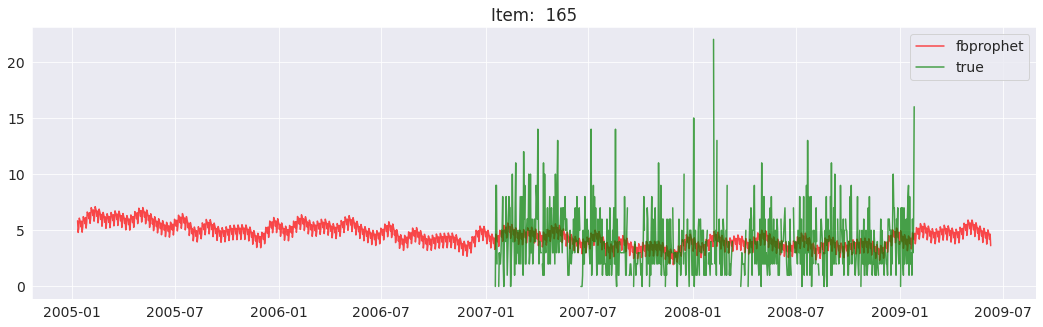

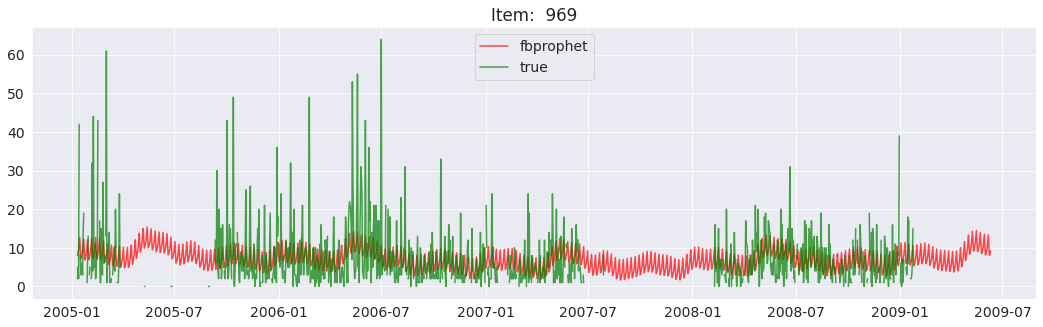

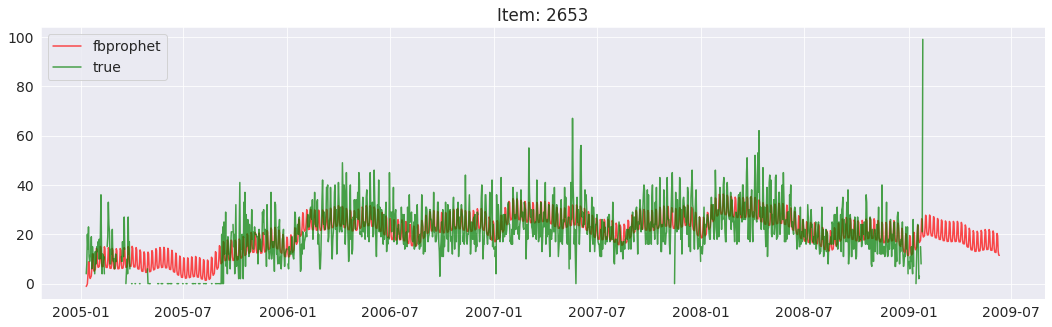

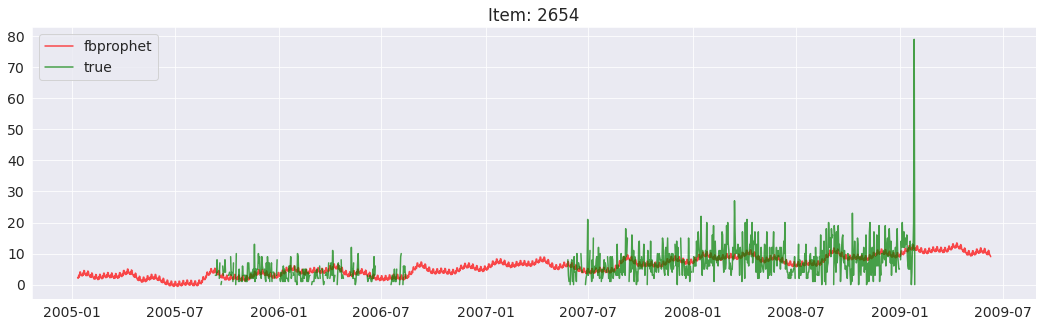

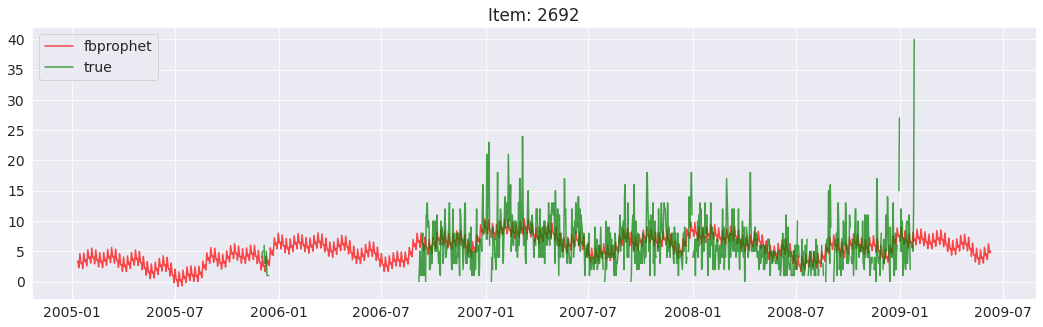

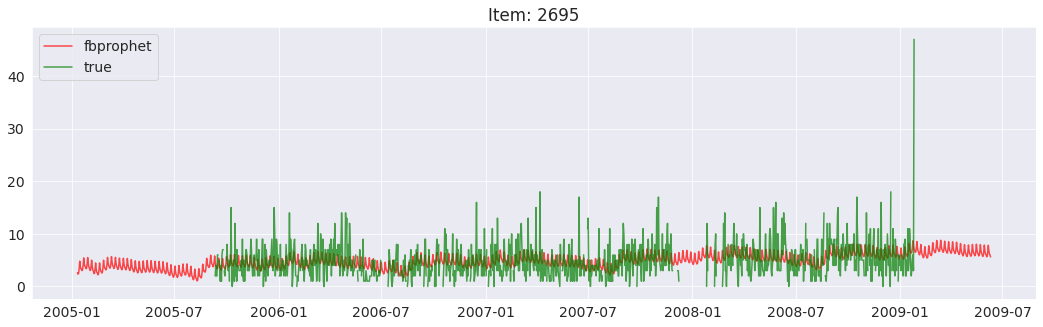

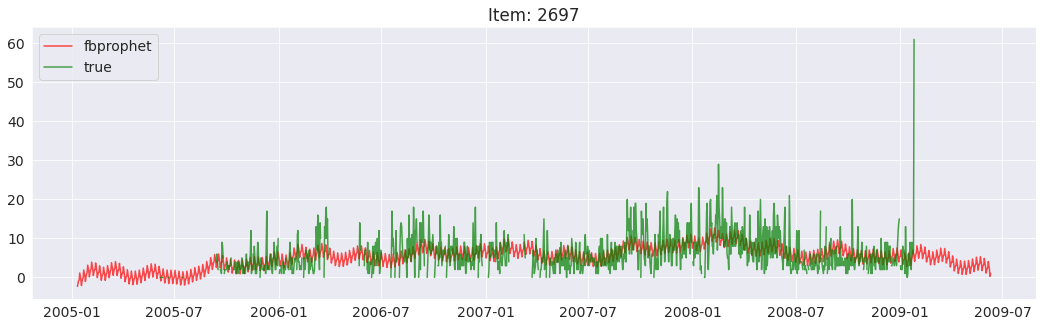

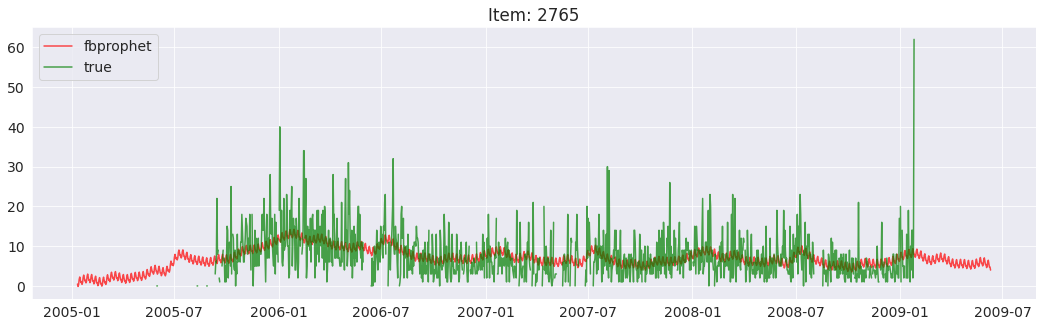

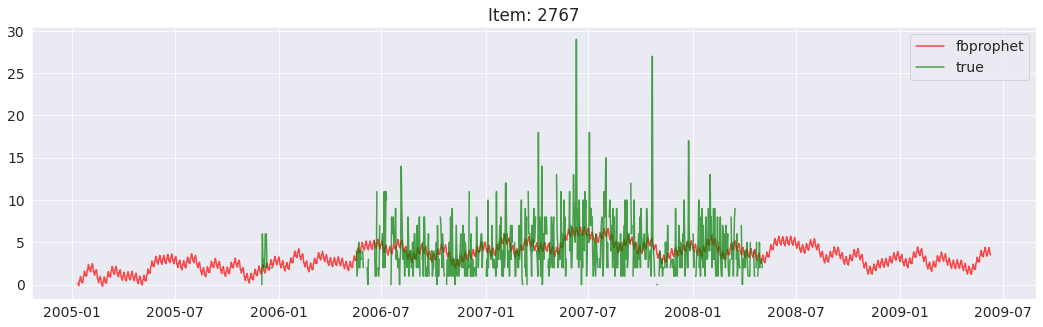

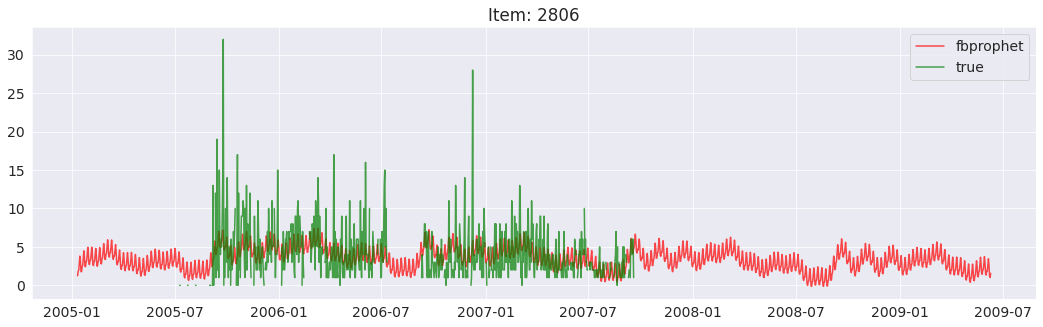

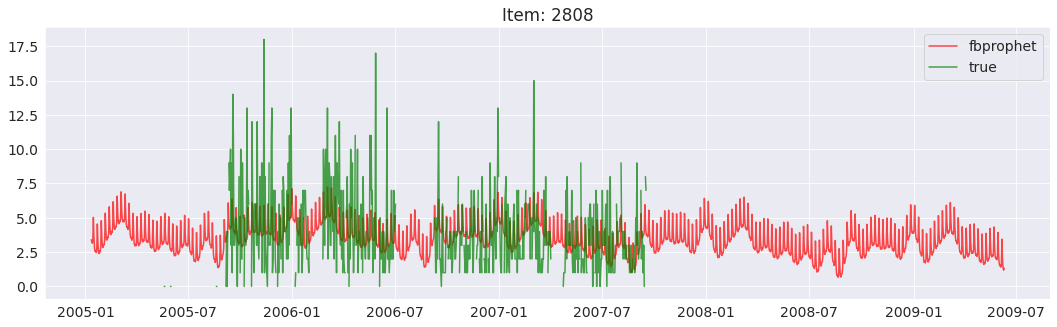

In [47]:
from fbprophet import Prophet

#suppressing the info logs
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts[col])
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_wholehist1.loc[col, 'FBP'],_ = qualityMAPE(df['y'], forecast.set_index('ds').loc[ts.index]['yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

In [49]:
# components of fbprophet model: there are many of them
forecast

ds     trend  ...  multiplicative_terms_upper      yhat
0    2005-01-11  3.505913  ...                         0.0  3.388986
1    2005-01-12  3.507174  ...                         0.0  3.385493
2    2005-01-13  3.508435  ...                         0.0  3.147412
3    2005-01-14  3.509695  ...                         0.0  3.277206
4    2005-01-15  3.510956  ...                         0.0  5.031798
...         ...       ...  ...                         ...       ...
1607 2009-06-06  2.678578  ...                         0.0  3.443690
1608 2009-06-07  2.677475  ...                         0.0  2.064741
1609 2009-06-08  2.676372  ...                         0.0  1.340280
1610 2009-06-09  2.675269  ...                         0.0  1.184491
1611 2009-06-10  2.674166  ...                         0.0  1.325677

[1612 rows x 19 columns]

In [50]:
# generate forecast with SES for h = 100 next days after fs_start_dt
fs_start_dt = '07-01-2007'
h = 100

ALPHA = [0.4, 0.2, .15, 0.1, 0.05, 0.01, 0.005]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=h, ts=ts[:fs_start_dt], AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)


quality_100days = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within first 100 steps after fs_start_dt
for model in quality_100days.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(pd.to_datetime(fs_start_dt), pd.to_datetime(fs_start_dt)+timedelta(h) )
        quality_100days[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

# ax = quality_100days[sorted(quality_100days.columns)].plot.bar(figsize = (25,4))
# ax.set_xlabel("Items")
# ax.set_ylabel("MAPE")

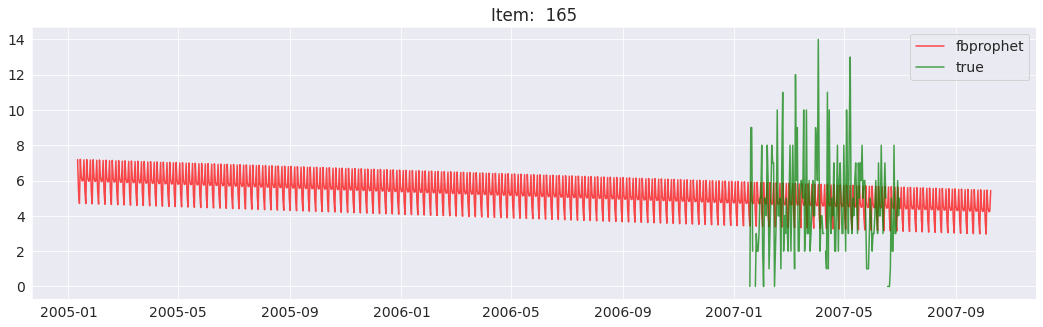

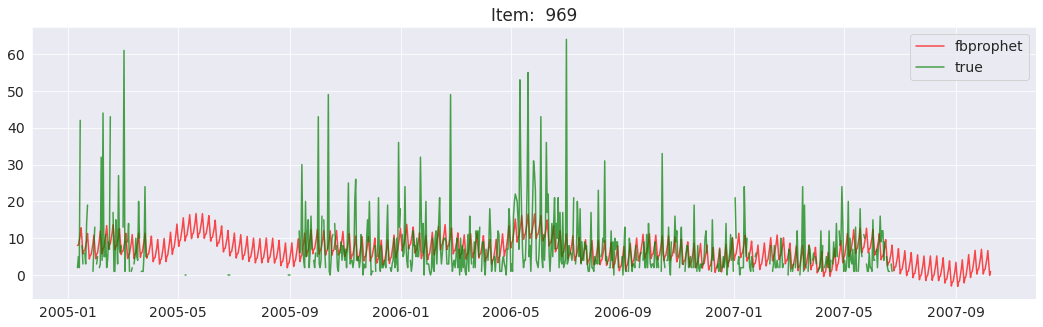

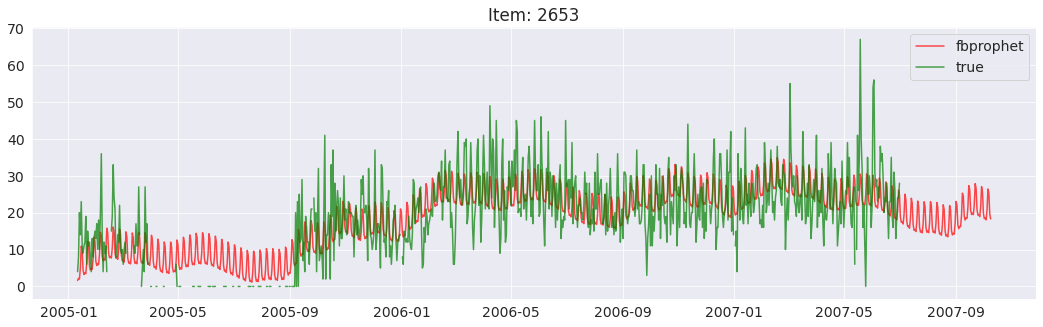

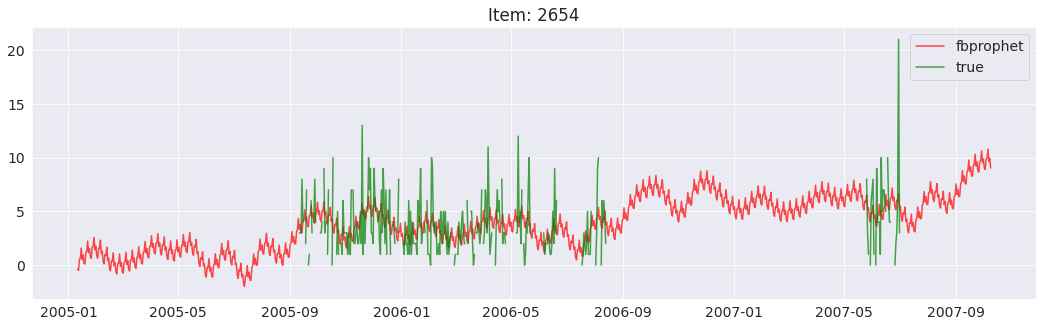

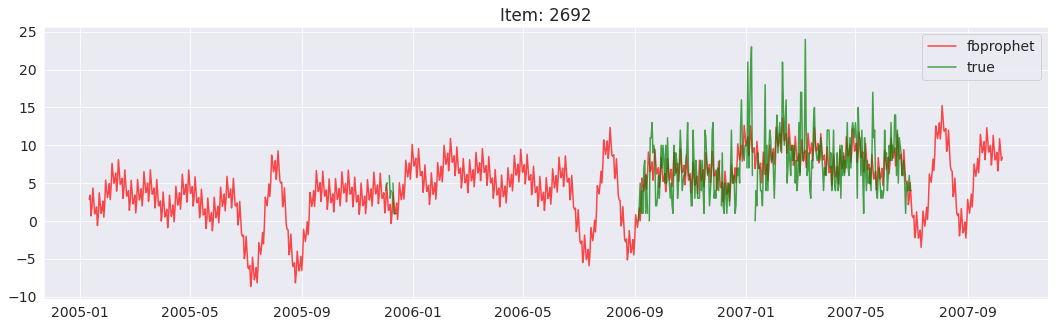

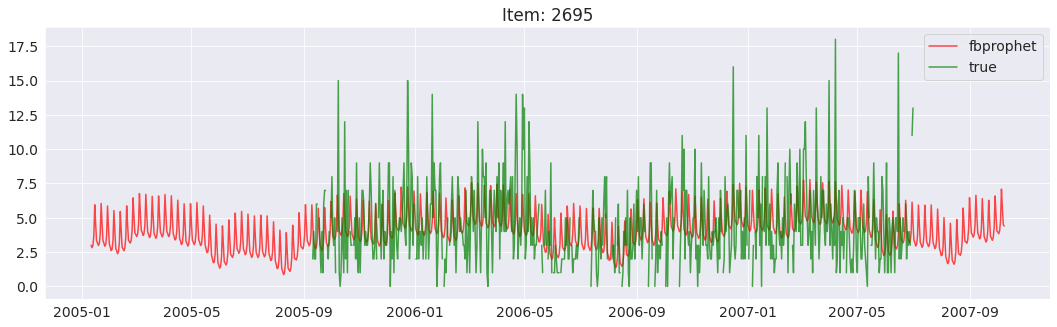

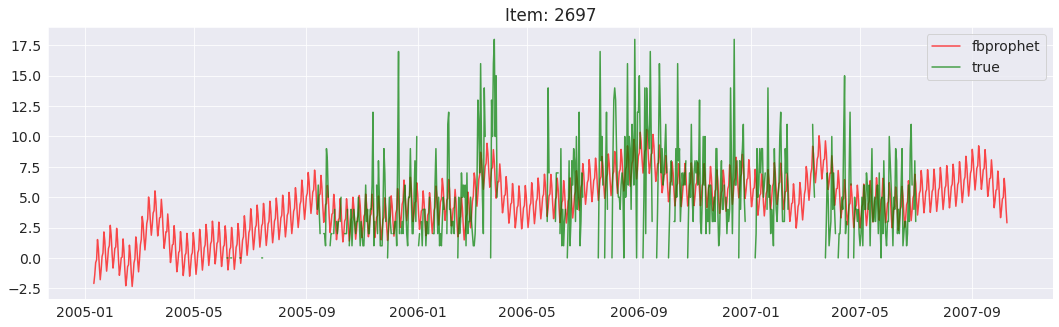

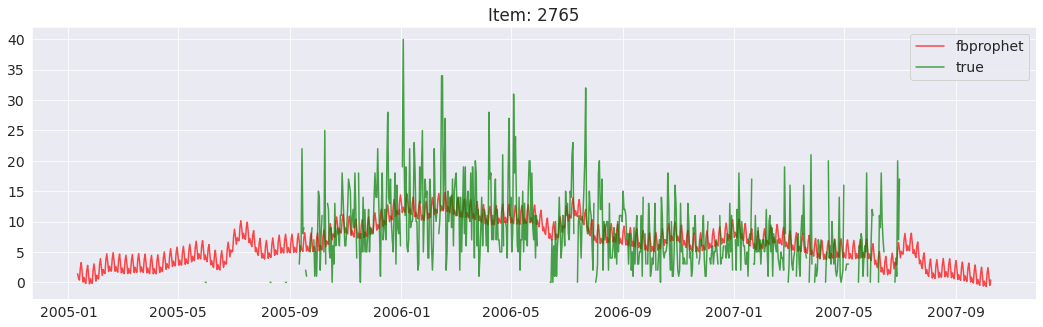

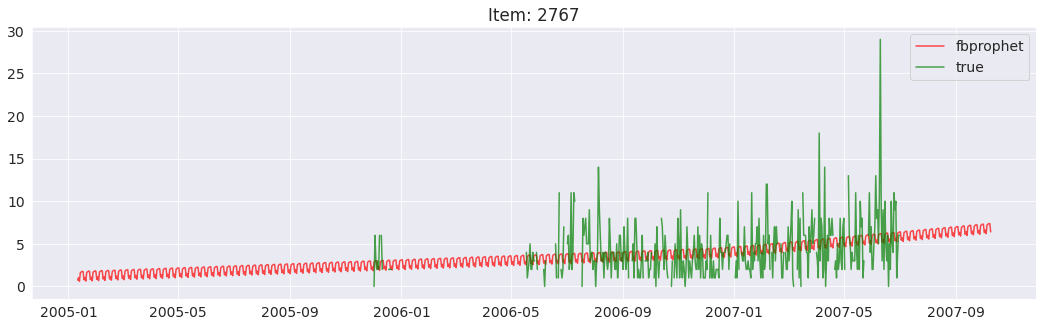

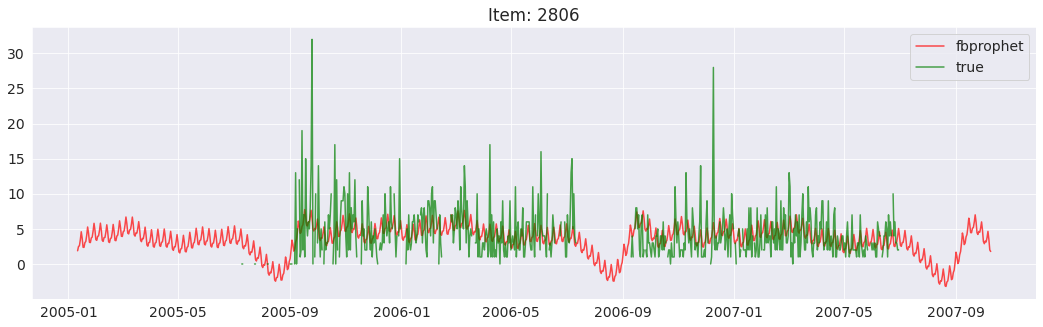

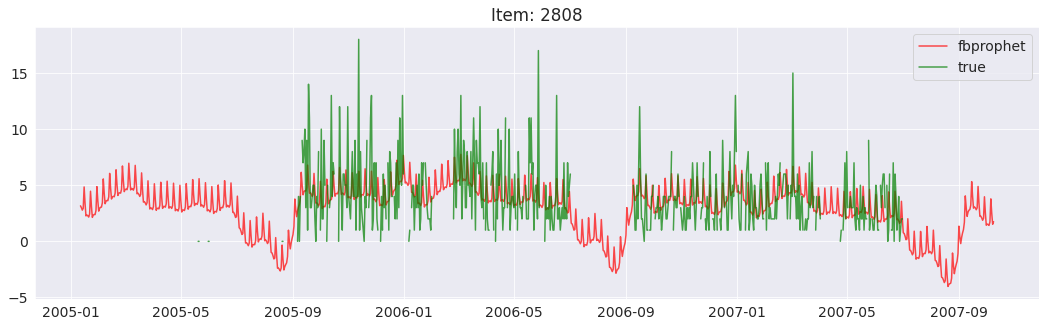

In [60]:
# generate forecast since fs_start_dt
for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts.loc[:fs_start_dt, col])
    df['ds'] = ts[:fs_start_dt].index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_100days.loc[col, 'FBP'],_ = qualityMAPE(ts.loc[fs_start_dt:, col], forecast.set_index('ds').loc[fs_start_dt:, 'yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

Text(0, 0.5, 'MAPE')

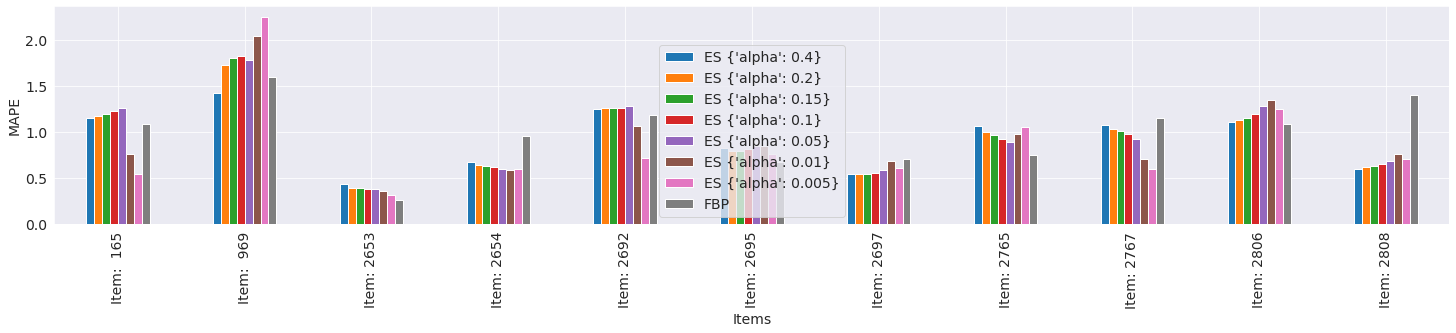

In [52]:
ax = quality_100days.plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

# Use Case
One story: https://www.youtube.com/watch?v=u3lhVV3wAKk

**Advantages of ES** (including those that will be covered in the next lesson)
* Easy to understand/explain (interpratability)
* Low computation time (train procedures are quite simple)
* Simple customization

**Disadvantages** of ES models: 
* Is not possible to consider external causals (drivers)
  - workaround: to forecast each driver-component (e.g. promo-drive and not promo-driven) separately 
* High possibility of overfitting (regular monitoring is required)

# Selfcheck questions
1. What part of ESM algorithm corresponds to "exponential" low?

2. What is the difference between Moving Average and EWMA? What are advantages each EWMA?

3. Which components are assumed to be present in ts according to Simple ES model?

4. Describe behavior of SES forecast when smoothing parameter goes to 0 (goes to 1). 

5. Write down and explain MAPE loss formula.

6. Which approaches do you know to solve initialization issue for Simple ES model?

7. How to define that Simple ES is not appropriate to a ts?

# Materials
* Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
* Hyndman R.J., Athanasopoulos G. Forecasting: principles and practice,2016. https://www.otexts.org/book/fpp